## <font color='green'>Setup 1</font>: Load Libraries

In [1]:
import sys
root_dir = "../"
sys.path.append(root_dir)

from test_bad_word import *
from utility import *

import time
import numpy as np
import pandas as pd
#pd.options.display.max_columns = None
#pd.options.display.mpl_style = 'default'
import tensorflow as tf
import seaborn as sns

import re
import os
import sys
import random
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import sparse

from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
    
stemmer = SnowballStemmer('english')

## <font color='green'>Setup 2</font>: Load Datasets

In [3]:
df_train = pd.read_csv('data/RNN_train.csv', encoding="ISO-8859-1")
df_test = pd.read_csv('data/RNN_test.csv', encoding="ISO-8859-1")
df_val = pd.read_csv('data/RNN_val.csv', encoding="ISO-8859-1")

num_train = df_train.shape[0]
num_test = df_test.shape[0]
num_val = df_val.shape[0]

In [10]:
def data_transform(file):
    data = []
    length = len(file)
    sentences = file['Comment'].values
    insults = file['Insult'].values
    for i in range(length):
        current_sentences = sentences[i]
        current_insult = insults[i]
        instance = {"sentences": current_sentences, "insult": current_insult}
        data.append(instance)
    return data

train = data_transform(df_train)
test = data_transform(df_test)
val = data_transform(df_val)

In [77]:
df_train['total length'] = df_train['sentences length'].map(lambda x: np.sum(eval(x)))
df_test['total length'] = df_test['sentences length'].map(lambda x: np.sum(eval(x)))
df_val['total length'] = df_val['sentences length'].map(lambda x: np.sum(eval(x)))

C:\Users\zcakz\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


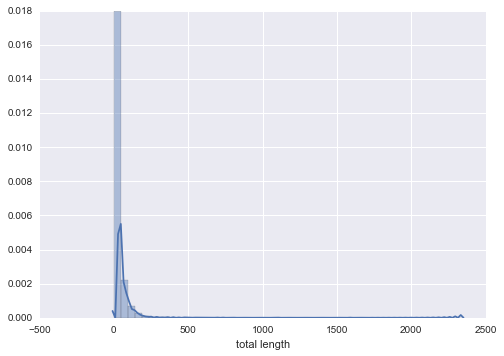

In [84]:
sns.distplot(df_train['total length'].append(df_test['total length']).append(df_val['total length']))

## <font color='green'>Setup 3</font>: Pipeline Datasets

* comment length: number of setences in a comment
* sentence length: number of words in a sentene

In [86]:
glove_size = 100

word_vector_list = []

#file= open('word2vec/glove.6B.%sd.txt' % glove_size, 'r', encoding='utf-8')
#file= open('word2vec/glove.840B.300d.txt', 'r', encoding='utf-8')
file= open('word2vec/glove.twitter.27B.%sd.txt' % glove_size, 'r', encoding='utf-8')
for line in file:
    line = line.rstrip().split(' ')
    word_vector_list.append(line[0])

In [87]:
def pipeline(data, max_sent_len = 250, vocab = None):
    if vocab is None:
        vocab = {'<PAD>': 0, '<OOV>': 1}
        
    out_sentences = np.full([len(data),  max_sent_len], 0, dtype=np.int32)
    sentences_length = []
    data_insults = []
    for i,instance in enumerate(data):
        sentence = instance['sentences'].split()
        sents = []
        for token in sentence[:max_sent_len]:
            token = token.lower()
            if token not in word_vector_list:
                token_id = vocab['<OOV>']
            elif token in word_vector_list and token not in vocab:
                vocab[token] = len(vocab)
                token_id = vocab[token]
            else:
                token_id = vocab[token]
            sents.append(token_id)
        data_insults.append(instance['insult'])
        if len(sents) <= max_sent_len:
            out_sentences[i, 0:len(sents)] = sents
            sentences_length.append(len(sents))
        else:
            out_sentences[i, 0: max_sent_len] = sents[:max_sent_len]
            sentences_length.append(max_sent_len)
    return out_sentences,sentences_length, np.array(data_insults), vocab

In [88]:
t_0 = time.time()

train_sentences, train_length, train_label, vocab = pipeline(train)
test_sentences, test_length, test_label, vocab = pipeline(test, vocab = vocab)
val_sentences, val_length, val_label, vocab = pipeline(val, vocab = vocab)

print('time: ',time.time() - t_0)

time:  330.0332717895508


In [93]:
np.save('Sentence-Level-Preprocessed-Data/train_sentence', train_sentences)
np.save('Sentence-Level-Preprocessed-Data/train_length', train_length)
np.save('Sentence-Level-Preprocessed-Data/train_label', train_label)

np.save('Sentence-Level-Preprocessed-Data/test_sentence', test_sentences)
np.save('Sentence-Level-Preprocessed-Data/test_length', test_length)
np.save('Sentence-Level-Preprocessed-Data/test_label', test_label)

np.save('Sentence-Level-Preprocessed-Data/val_sentence', val_sentences)
np.save('Sentence-Level-Preprocessed-Data/val_length', val_length)
np.save('Sentence-Level-Preprocessed-Data/val_label', val_label)

## <font color='green'>Setup 4</font>: Word2Vec

In [94]:
import collections
import operator

glove_size = 100

word_dict= collections.defaultdict(list)
vocab_keys = vocab.keys()

#file= open('word2vec/glove.6B.%sd.txt' % glove_size, 'r', encoding='utf-8')
file= open('word2vec/glove.twitter.27B.%sd.txt' % glove_size, 'r', encoding='utf-8')
#file= open('word2vec/glove.840B.300d.txt', 'r', encoding='utf-8')
for line in file:
    line = line.rstrip().split(' ')
    if line[0] in vocab_keys:
        word_dict[line[0]]=[float(i) for i in line[1:]]
    
word_dict=dict(word_dict)

In [95]:
sorted_vocab = sorted(vocab.items(), key=operator.itemgetter(1))

embedding_list=[]
#OOV_vector = [random.uniform(-1, 1) for i in range(glove_size)]
OOV_vector  = np.mean(list(word_dict.values()),axis=0)

for item in sorted_vocab:
    if item[0]== '<PAD>':
        embedding_list.append(np.array([0 for i in range(glove_size)], dtype='f'))
    elif item[0] =='_cr_':
        embedding_list.append(word_dict['fuck'])
    elif item[0] in word_dict:
        embedding_list.append(word_dict[item[0]])
    else:
        if item[0] in bad_word:
            embedding_list.append(word_dict['fuck']) 
        else:
            embedding_list.append(OOV_vector)
        #embedding_list.append('unseen')
       
W = np.array(embedding_list)
#print("unseen ratio:", embedding_list.count('unseen')/len(vocab))

In [96]:
np.save('Sentence-Level-Preprocessed-Data/embedding', W)